In [1]:
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))


import numpy as np
from scipy.optimize import differential_evolution
from stress_strain_analysis import stress_strain_analysis
from mesh import Mesh
import geometry

# Define your geometry and mesh
ReinforcedConcrete = geometry.ReinforcedConcreteColumn(width  = 300, 
                                                       height = 300, 
                                                       concrete_cover = 30,
                                                       rebar_diameter = 20,
                                                       rebar_spacing  = 50)
Mesh = Mesh(ReinforcedConcrete, "triangle", 25)

In [2]:
import time
# Initialize the stress-strain analysis
analysis = stress_strain_analysis(Mesh, Nx=80, My=13)

def callback(xk, convergence):
    residual = analysis.find_strain_and_curvature(xk)
    print(f"Residual: {residual}")
    return residual < 1e-9  # Stop when condition is met

# Define bounds for eps and xsi
bounds = [(-0.01, 0.01), (-0.001, 0.001)]
start_time = time.perf_counter()
result = differential_evolution(analysis.find_strain_and_curvature, 
                                bounds=bounds, 
                                callback=callback,
                                tol=1e-6,  # Additional tolerance setting
                                strategy='best1bin', 
                                maxiter=1000)

# End timing
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time

print("Optimal solution:", result.x)
print("Number of iterations:", result.nit)
print("Minimum residual:", result.fun)
print(f"Execution Time: {elapsed_time:.4f} seconds")

Residual: 92.24169676073828
Residual: 92.24169676073828
Residual: 92.24169676073828
Residual: 91.62447463570751
Residual: 91.62447463570751
Residual: 89.63937151853973
Residual: 89.63937151853973
Residual: 89.63937151853973
Residual: 89.63937151853973
Residual: 88.18982175544556
Residual: 83.85603004688711
Residual: 81.88970269003433
Residual: 81.88970269003433
Residual: 81.88970269003433
Residual: 81.88970269003433
Residual: 81.88970269003433
Residual: 81.88970269003433
Residual: 81.88970269003433
Residual: 81.88970269003433
Residual: 81.80842365419387
Residual: 81.80842365419387
Residual: 81.80842365419387
Residual: 81.80842365419387
Residual: 81.80842365419387
Residual: 81.80842365419387
Residual: 81.80198564161174
Residual: 81.8017334892584
Residual: 81.77536911142522
Residual: 81.7698456128513
Residual: 81.76668820332634
Residual: 81.76116845122479
Residual: 81.75696154475558
Residual: 81.75463005238569
Residual: 81.75463005238569
Residual: 81.75463005238569
Residual: 81.754630052

In [3]:
from scipy.optimize import fsolve
target_N = 1000
target_M = 60
# Define system of equations for fsolve
def system_of_equations(V, target_N, target_M):
    # Set strain and curvature
	analysis.set_strain_and_curvature(V[0], V[1])

    # Calculate section forces
	analysis.calculate_strains()
	analysis.calculate_stresses()
	Nx, My = analysis.get_section_forces()
	print(Nx, My)
    # Return the system of equations
	return [Nx - target_N, My - target_M]

# Initial guess for eps and xsi
initial_guess = [0.0000, 0.00000]  


start_time = time.perf_counter()
# Solve with fsolve
result = fsolve(system_of_equations, initial_guess, args=(target_N, target_M))
# End timing
end_time = time.perf_counter()
# Calculate elapsed time
elapsed_time = end_time - start_time

print("Optimal Solution:", result)
print("Residual (Post-Check):", system_of_equations(result, target_N, target_M))
print(f"Execution Time: {elapsed_time:.4f} seconds")


0.0 0.0
0.0 0.0
0.0 0.0
0.048748468072189015 1.0658141036401503e-19
4.7073456244106636e-17 0.3922091421379769
99.82048454660377 5.989229072794628
299.4614536398106 17.967687218384278
698.743391826225 41.924603509565245
999.2089050406166 59.885324330817625
999.9335855146549 59.990403105116336
999.9999412817825 59.99999184375789
1000.0000001391838 60.00000002010763
1000.0000000003264 60.00000000004712
Optimal Solution: [3.05939148e-04 2.28434158e-06]
1000.0000000003264 60.00000000004712
Residual (Post-Check): [3.263949110987596e-10, 4.7123194235609844e-11]
Execution Time: 0.0020 seconds


0.00030593914788079184 2.2843415809446517e-06
Nx =  1000.0000000003264 kN
My =  60.00000000004712 kNm


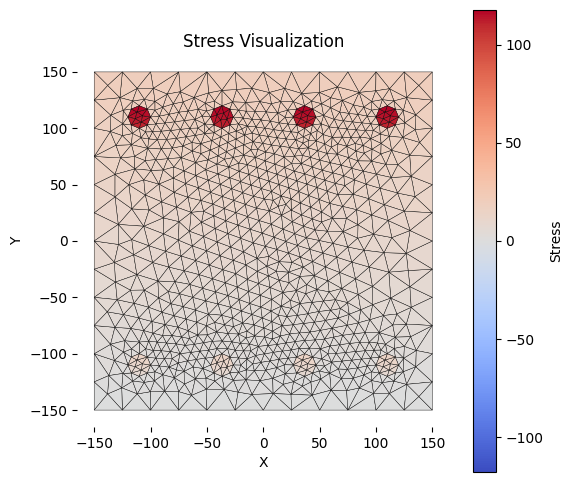

In [4]:
eps, xsi = result[0],result[1]
print(eps, xsi)
analysis.set_strain_and_curvature(eps, xsi)
analysis.calculate_strains()
analysis.calculate_stresses()
print("Nx = ", analysis.get_section_forces()[0], "kN")
print("My = ", analysis.get_section_forces()[1], "kNm")
analysis.plot_stresses()

C:\Users\fabio\AppData\Local\Temp\ipykernel_21780\2868503945.py:25: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(equilibrium_equation, initial_guess)
C:\Users\fabio\AppData\Local\Temp\ipykernel_21780\2868503945.py:25: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(equilibrium_equation, initial_guess)


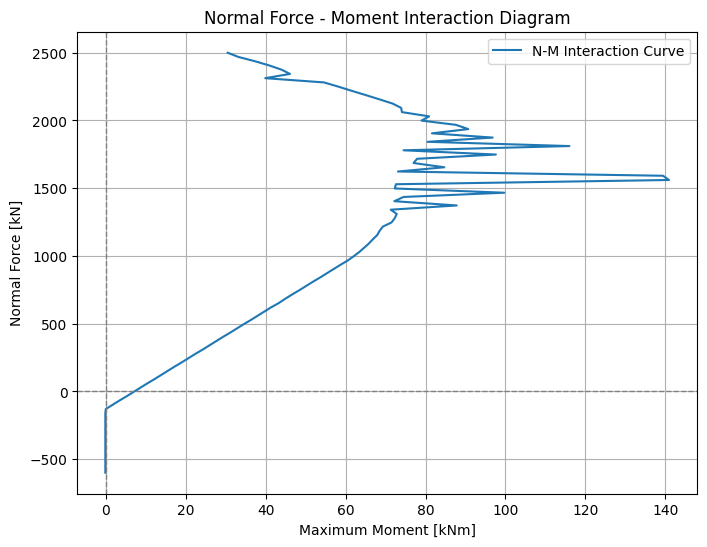

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, M_target):
    analysis.set_strain_and_curvature(V[0], V[1])
    analysis.calculate_strains()
    analysis.calculate_stresses()
    Nx, My = analysis.get_section_forces()
    return [Nx - N_target, My - M_target]

# Function to calculate maximum moment for a given normal force
def max_moment_for_normal_force(N_target, tolerance=1e-3, step_size=0.1):
    M_max = 0  # Starting point for maximum moment
    success = True
    
    while success:
        def equilibrium_equation(V):
            return system_of_equations(V, N_target, M_max)

        initial_guess = [0.00, 0.0]
        
        try:
            solution = fsolve(equilibrium_equation, initial_guess)

            # Check if equilibrium holds
            analysis.set_strain_and_curvature(solution[0], solution[1])
            analysis.calculate_strains()
            analysis.calculate_stresses()
            Nx, My = analysis.get_section_forces()

            # Stop when equilibrium deviates beyond tolerance
            if abs(Nx - N_target) > tolerance or abs(My - M_max) > tolerance:
                success = False
            else:
                M_max += step_size  # Continue increasing the moment
        except RuntimeError:
            # If `fsolve` fails to converge, stop the loop
            success = False

    return M_max - step_size  # Return the last successful moment

# Generate data points
normal_forces = np.linspace(-600, 2500, 100)  # Example range of normal forces (in kN)
moments = [max_moment_for_normal_force(N) for N in normal_forces]

# Plot the N-M Interaction Diagram
plt.figure(figsize=(8, 6))
plt.plot(moments, normal_forces, label='N-M Interaction Curve')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.ylabel("Normal Force [kN]")
plt.xlabel("Maximum Moment [kNm]")
plt.title("Normal Force - Moment Interaction Diagram")
plt.legend()
plt.grid(True)
plt.show()
